# Lab exercise #1: Linear regression and Gaussian distributions

CS-E4075 (2021)

### Learning objectives

The purpose of this exercise is to become familiar with the multivariate Gaussian distribution and the basics of Bayesian inference. 

After completing the exercise, you should be able to:

- Manipulate, implement, and sample from  multivariate Gaussian densities


- Explain the role of the prior, likelihood, posterior, and model evidence in Bayesian inference.


- Derive the posterior distribution of the regression weight for a ridge regression model. 


You are only allowed to use the numpy module to solve the exercises and **not** statistics specific modules (e.g scipy.stats or GPy)

In [2]:
%matplotlib inline
import numpy as np
import pylab as plt
import seaborn as snb
snb.set(font_scale=1.5)

### Gaussian linear regression

Linear regression is perhaps the most frequently used technique in applied statistics for modelling the relationship between set of a covariates $\left\lbrace \mathbf{x}_n \right\rbrace_{n=1}^N$ and a response variable $\left\lbrace y_n \right\rbrace_{n=1}^N$. More formally, let $\mathbf{X} \in \mathbb{R}^{N \times D}$ be a design matrix and let  $\mathbf{y} \in \mathbb{R}^N$ be the response variables, then the linear regression model is given by

\begin{align}
\mathbf{y} = \mathbf{X}\mathbf{w} + \mathbf{e},
\end{align}


where $\mathbf{w} \in \mathbb{R}^D$ is the regression weights and $\mathbf{e} \in \mathbb{R}^N$ is a noise vector.

Assuming isotropic Gaussian noise and imposing a multivariate Gaussian prior on $\mathbf{w} \sim \mathcal{N}\left(\mathbf{m}, \mathbf{S}\right)$ gives rise to the following joint distribution


\begin{align}
p(\mathbf{y}, \mathbf{w}) = p\left(\mathbf{y}|\mathbf{w}\right)p\left(\mathbf{w}\right) = \mathcal{N}\left(\mathbf{y}\big|\mathbf{Xw}, \sigma^2\mathbf{I}\right)\mathcal{N}\left(\mathbf{w}\big|\mathbf{m}, \mathbf{S}\right).
\end{align}


In this exercise, we will use the following simple model as running example:


\begin{align}
y_n = ax_n + b +  e_n = \begin{bmatrix}x_n&1\end{bmatrix}\begin{bmatrix}a\\b\end{bmatrix} + e_n.
\end{align}


That is, $\mathbf{w} = \left[a, b\right]$, where $a$ and $b$ are the slope and intercept of the line, respectively. Furthermore, we will assume $\mathbf{m} = \mathbf{0}$, $\mathbf{S} = 10\cdot\mathbf{I}$, and $\sigma^2 = 2$.



We will use the following data set with $N = 20$ data points

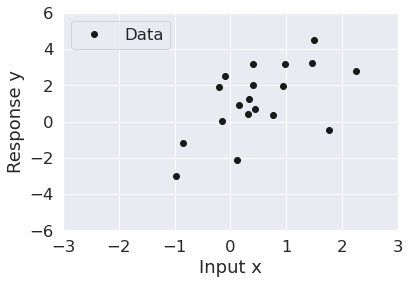

In [3]:
# hyperparameters of the prior
m = np.zeros((2, 1))
S = 10*np.identity(2)

# noise variance
sigma2 = 2

# data
N = 20
x = np.array([1.764, 0.4, 0.979, 2.241, 1.868, -0.977,  0.95, -0.151, -0.103, 0.411, 0.144, 1.454, 0.761, 0.122,
              0.444, 0.334, 1.494, -0.205,  0.313, -0.854])[:, None]
y = np.array([-0.464, 2.024, 3.191, 2.812, 6.512, -3.022, 1.99, 0.009, 2.513, 3.194, 0.935, 3.216, 0.386, -2.118,
               0.674, 1.222, 4.481, 1.893, 0.422,  -1.209])[:, None]

# plot
plt.plot(x, y, 'k.', label='Data', markersize=12)
plt.xlabel('Input x')
plt.ylabel('Response y')
plt.legend()
plt.xlim((-3, 3))
plt.ylim((-6, 6));

### Task 1: The prior, likelihood and posterior

The purpose of this task is to implement the basic building blocks of the linear model. In the cells below, you are given a set of function templates and the task is to complete the implementations as specified below.

Hint: look for Rasmussen book section 2.1 (http://www.gaussianprocess.org/gpml/)

- **Task 1a**: Implement the multivariate gaussian density function using numpy (Hint: to avoid numerical problems, always add a small diagonal constant to covariance matrices)

\begin{align}
N(x | \mu, \Sigma ) = (2\pi)^{-\frac{D}{2}} | \Sigma |^{-\frac{1}{2}} \exp\left[-\frac{1}{2}(x - \mu)^T \Sigma^{-1} (x - \mu) \right]
\end{align}



In [4]:
def mvn_pdf(x, mu, Sigma, log=True):
    """ Returns the log density of a multivariate Gaussian distribution
    with mean mu and covariace Sigma at point x
    
    Arguments:
    x     -- (Dx1) evaluation point
    mu    -- (Dx1) mean vector
    Sigma -- (DxD) covariance matrix
    log   -- (bool) if true, return log density. If false, return (default=True)
      
    Returns:
    (scalar) density
    """

    ###############################################
    # ------- insert code here -------------------
    ###############################################
    assert x.shape[0]==mu.shape[0]==Sigma.shape[0]==Sigma.shape[1]
    D=x.shape[0]
    Sigma = Sigma + 1e-8*np.identity(D)
    if log:
        density=(-D/2)*np.log(2*np.pi)-0.5*np.log(np.linalg.det(Sigma))-0.5*(x-mu).T@np.linalg.inv(Sigma)@(x-mu)
    else:
        density=((2*np.pi)**(-D/2))*(np.linalg.det(Sigma)**(-0.5))*(np.exp(-0.5*((x-mu).T@np.linalg.inv(Sigma)@(x-mu))))
    return density

- **Task 1b**: Implement functions to evaluate log density of the (i) prior, (ii) likelihood and (iii) posterior using the <tt>mvn_pdf</tt> function above. Hint: Use the function <tt>predict(x, a, b)</tt> given below

In [5]:
def predict(x, a, b):
    """ returns prediction for inputs x given parameter (a,b)
    
    Arguments:
    x    --  (Nx1) vector of inputs
    a    --  slope parameter
    b    --  intercept parameter
    
    Returns:
    (Nx1) vector of predictions
    """
    return a*x + b


def log_prior(a, b):
    """ returns the log density of the prior at the points (a,b) given m and S
    
    Arguments:
    a    -- (scalar) slope parameter
    b    -- (scalar) intercept parameters
    
    Returns
    (scalar) log density for the pair (a,b)
    
    """
    
    ###############################################
    # ------- insert code here -------------------
    return mvn_pdf(np.array([[a],[b]]),m,S,True)
    ###############################################
    


def log_likelihood(x, y, a, b):
    """ returns the log likelihood for the data (x,y) given the parameters (a,b)
    
    Arguments:
    x    -- (Nx1) vector of inputs
    y    -- (Nx1) vector of responses
    a    --  slope parameter
    b    --  intercept parameter
    
    Returns:
    (scalar) log likelihood of (x,y) 
    """
    
    ###############################################
    # ------- insert code here -------------------
    y_estimate=predict(x,a,b)
    sigma=sigma2*np.identity(x.shape[0])
    return mvn_pdf(y,y_estimate,sigma,True)
    ###############################################
    
    
    

def log_posterior(x, y, a, b):
    """ returns the log posterior for the data (x,y) given the parameters (a,b)
    
    Arguments:
    x    -- (Nx1) vector of inputs
    y    -- (Nx1) vector of responses
    a    --  slope parameter
    b    --  intercept parameter
    
    Returns:
    (scalar) log posterior of (x,y)
    """
    
    ###############################################
    # ------- insert code here -------------------
    return log_prior(a,b)+log_likelihood(x,y,a,b)
    ###############################################

- **Task 1c**: The goal of this task is to make contour plots of the prior density, the likelihood and the posterior as a function of (a,b) in the intervals $-6 \leq a \leq 6$ and $-6 \leq b \leq 6$, respectively, by completing the implementation of the functions: <tt>plot_prior_density</tt>,  <tt>plot_likelihood</tt>,  <tt>plot_posterior_density</tt> given below. 

Hint: Check the numpy function <tt>meshgrid</tt> and pyplot function <tt>contour</tt> to plot 2D densities.

In [6]:
a = np.arange(-6, 6, 0.1)
b = np.arange(-6, 6, 0.1)
xx, yy = np.meshgrid(a, b)

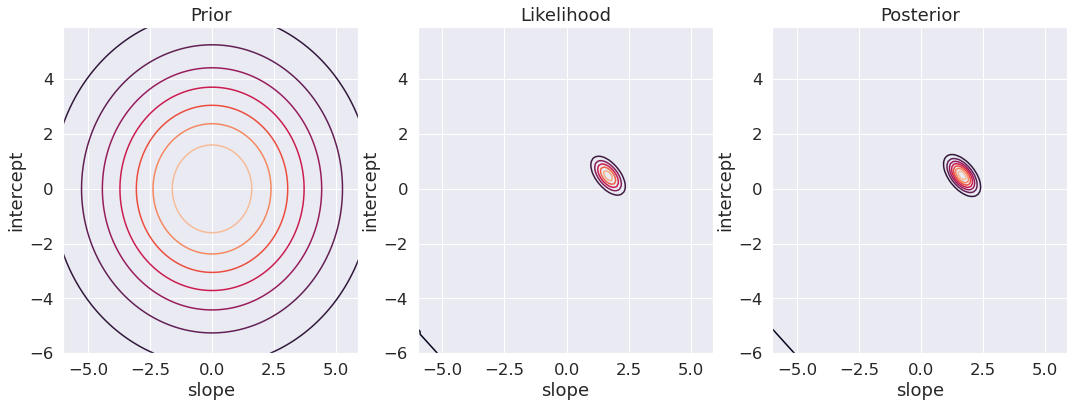

In [7]:

def plot_prior_density():
    z=np.zeros((120,120))
    ###############################################
    # ------- insert code here -------------------
    for i in range(120):
        for j in range(120):
            a=xx[i,j]
            b=yy[i,j]
            z[i,j]=log_prior(a,b)
    plt.contour(xx,yy,np.exp(z))
    ###############################################
    plt.xlabel('slope')
    plt.ylabel('intercept');
    
def plot_likelihood(x, y):
    z=np.zeros((120,120))
    ###############################################
    # ------- insert code here -------------------
    for i in range(120):
        for j in range(120):
            a=xx[i,j]
            b=yy[i,j]
            z[i,j]=log_likelihood(x,y,a,b)
    plt.contour(xx,yy,np.exp(z))
    ###############################################
    plt.xlabel('slope')
    plt.ylabel('intercept');

def plot_posterior_density(x, y):
    z=np.zeros((120,120))
    ###############################################
    # ------- insert code here -------------------
    for i in range(120):
        for j in range(120):
            a=xx[i,j]
            b=yy[i,j]
            z[i,j]=log_posterior(x,y,a,b)
    plt.contour(xx,yy,np.exp(z))
    ###############################################
    
    plt.xlabel('slope')
    plt.ylabel('intercept');

    
# plot
plt.figure(figsize=(18,6))
plt.subplot(1, 3, 1)
plot_prior_density()
plt.title('Prior')

plt.subplot(1, 3, 2)
plot_likelihood(x, y)
plt.title('Likelihood')

plt.subplot(1, 3, 3)
plot_posterior_density(x, y)
plt.title('Posterior');

### Task 2: Analytical expression of the posterior distribution

- **Task 2a**: Show that the posterior is given by $p(\mathbf{w}\big|\mathbf{y}) = \mathcal{N}\left(\mathbf{w}\big|\mu, \Sigma\right)$, where


\begin{align}
\Sigma &= \left(\frac{1}{\sigma^2}\mathbf{X}^T\mathbf{X} + \mathbf{S}^{-1}\right)^{-1}\\
\mu &= \Sigma\left(\frac{1}{\sigma^2}\mathbf{X}^T\mathbf{y} + \mathbf{S}^{-1}\mathbf{m}\right)
\end{align}

Hints:
1. Use Bayes rule to obtain an expression for the posterior $p(\mathbf{w}\big|\mathbf{y})$ in terms of the prior, likehood and marginal likelihood
2. Take the logarithm on both sides and expand the right hand side
3. Conclude that only a subset of the terms depends on $\mathbf{w}$. Replace all terms independent of $\mathbf{w}$ with a constant
4. Argue that the posterior distribution must be Gaussian as the remaining terms on the right hand side is a quadratic function of $\mathbf{w}$. 
5. Determine the posterior mean and covariance by 'completing the square' or by comparing the coefficients of the quadractic functions to the logarithm of a multivariate Guassian distribution with mean $\mu$ and covariance $\Sigma$.

For background see Rasmussen section 2.1.1.

***Write your derivation here *** 

You can write in latex or you can also write it using pen and paper and attach a photo.

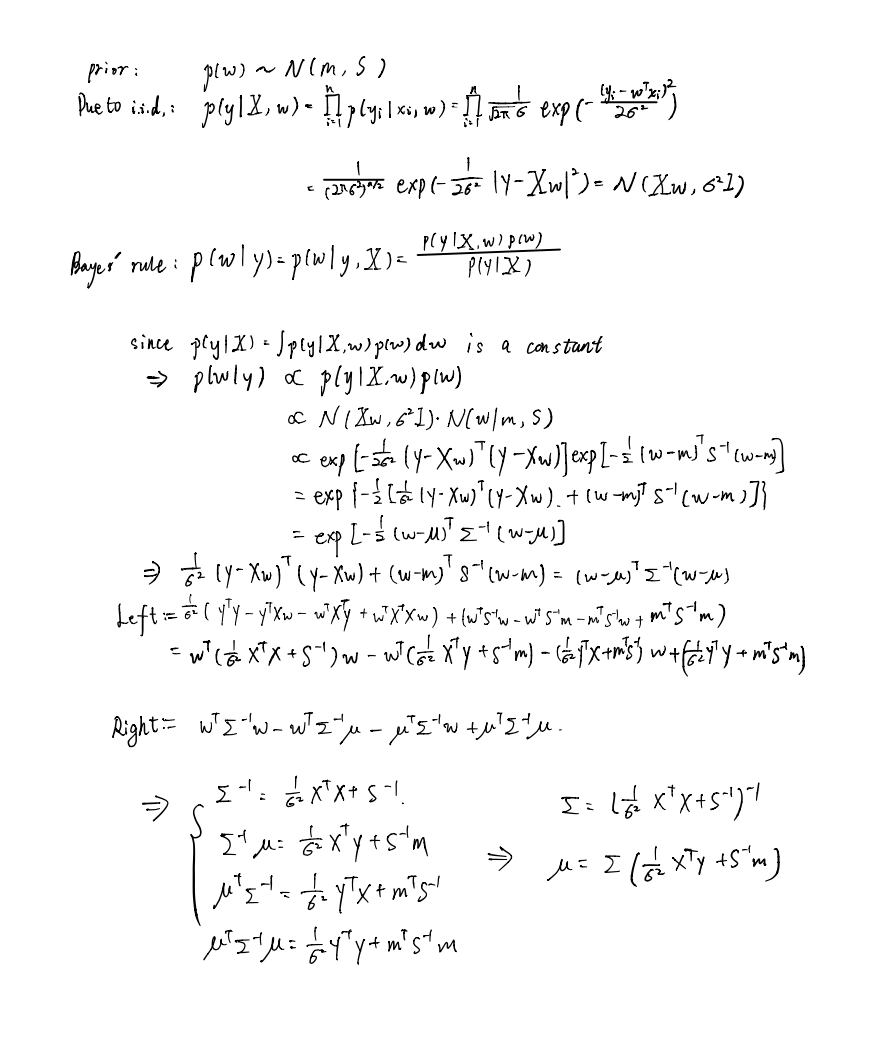

- **Task 2b**: Complete the implementation of the function for computing the analytical posterior distribution given below. Hint: The function <tt>design_matrix</tt> maps from a vectors of input $\mathbf{x}$ to the design matrix $\mathbf{X}$.

In [9]:
def design_matrix(x):
    """ returns the design matrix for a vector of input values x 
    
    Arguments:
    x    -- (Nx1) vector of inputs
    
    Returns:
    (Nx2) design matrix
    
    """
    X = np.column_stack((x, np.ones(len(x))))
    return X

def compute_posterior(x, y, m, S, sigma2):
    """ return the posterior mean and covariance of w given (x,y) 
    and hyperparameters m, S and sigma2
    
    Arguments:
    x      -- (Nx1) vector of inputs
    y      -- (Nx1) vector of responses
    m      -- (Dx1) prior mean
    S      -- (DxD) prior covariance
    sigma2 -- (scalar) noise variance
    
    Returns:
    mu     -- (Dx1) posterior mean
    Sigma  -- (DxD) posterior covariance
    
    """
    
    X = design_matrix(x)
    ###############################################
    # ------- insert code here -------------------
    Sigma=np.linalg.inv(1/sigma2*(X.T@X)+np.linalg.inv(S))
    mu=Sigma@(1/sigma2*(X.T@y)+np.linalg.inv(S)@m)
    ###############################################
    
    return mu, Sigma
    

- **Task 2c**: Using the function above, compute the posterior mean and covariance for the data set $(\mathbf{x}, \mathbf{y})$. Plot the resulting density and check that it matches the posterior distribution from task 1d.

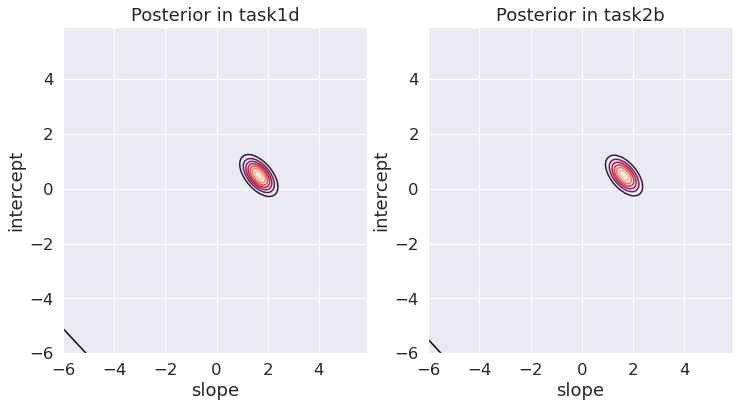

In [11]:
###############################################
# ------- insert code here -------------------
mu,Sigma=compute_posterior(x,y,m,S,sigma2)

z=np.zeros((120,120))
for i in range(120):
    for j in range(120):
        a=xx[i,j]
        b=yy[i,j]
        z[i,j]=mvn_pdf(np.array([[a],[b]]),mu,Sigma,True)
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plot_posterior_density(x, y)
plt.title('Posterior in task1d')
plt.subplot(1, 2, 2)
plt.contour(xx,yy,np.exp(z))
plt.xlabel('slope')
plt.ylabel('intercept');
plt.title('Posterior in task2b');
plt.show()
###############################################



### Task 3: Combining all of the above

In this task, you will use all the functions you implemented above to perform compute the posterior distribution $p\left(\mathbf{w}|\mathbf{y}\right)$ for various sizes of $N$. The cell below analyses the data set using $N = \left\lbrace 1, 2, 10, 20 \right\rbrace$ data points, where the columns visualise (i) data and sample functions, (ii) the prior, (iii) the likelihood and (iv) posterior. 

- **Task 3a**: The code below is complete, and works without issues if you have implemented all previous tasks. Make sure the code works and you can see the four visualisations.

- **Task 3b**: Study the code and plots and explain what you see. How does the blue lines in the first column relate to the blue dots in the fourth column? What happens as the number of samples increase? Why does the prior have so little effect in the last row?

1. Slopes and intercepts of the blue lines in the first column constitute the x and y coordinates of the blue points in the fourth column.

2. When limited sample provided, the posterior distribution variance is large since few information is provided. Its behavior is more like 'guess'. When samples increase, more information makes posterior distribution shrinks into a specitic location in hyperspace. The variance of distribution reduced. The model is more 'confident' to predict the result.

3. As we know, posterior consists of the product of prior and likelihood. In this case, we define a weakly informative prior, which is easily persuaded by data. As we see in the third column, the likelihood density is already 0 in some area, which will definitely ignore prior after multiplication. The main reason of this phenomenon is due to weakly informative prior.


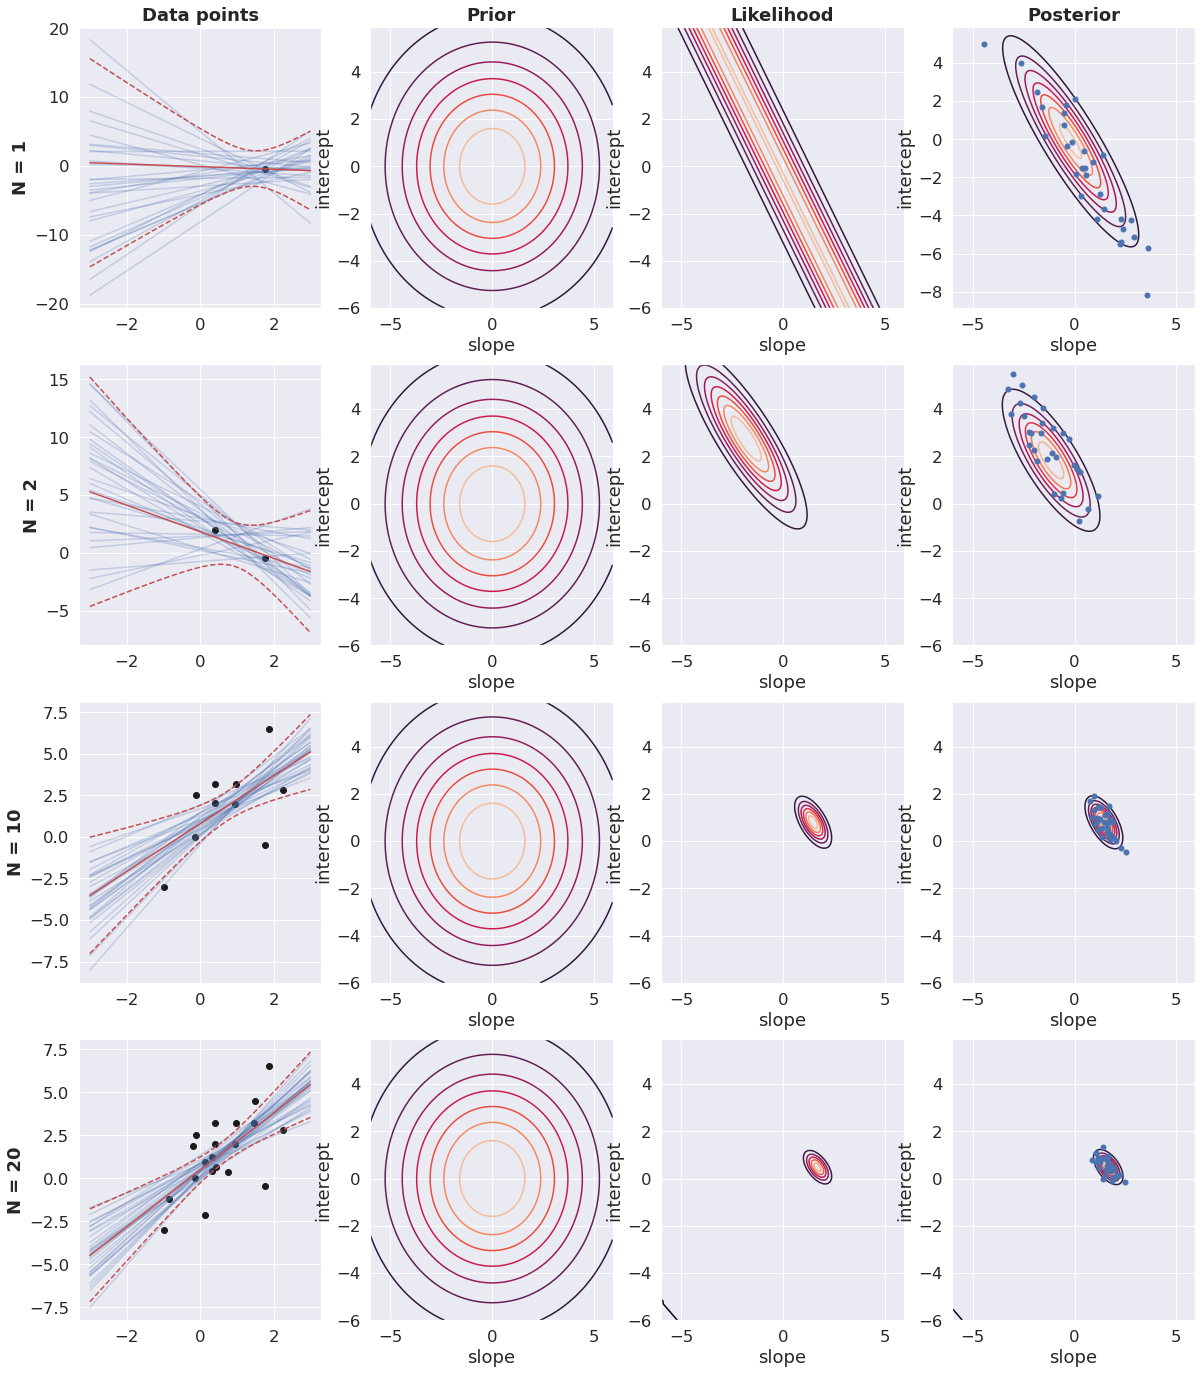

In [30]:
def generate_mvn_samples(mu, Sigma, M):
    """ return samples from a multivariate normal distribution N(mu, Sigma)

    Arguments:
    mu      -- (Dx1) mean vector
    Sigma   -- (DxD) covariance matrix
    M       -- (scalar) number of samples
    
    Returns:
    (DxM) matrix, where each column corresponds to a sample
    """
    
    jitter = 1e-8
    D = len(mu)
    L = np.linalg.cholesky(Sigma + jitter*np.identity(D))
    zs = np.random.normal(0, 1, size=(D, M))
    fs = mu + np.dot(L, zs)
    return fs

def compute_f_posterior(x, mu, Sigma):
    """ compute the posterior distribution of f(x) wrt. posterior distribution N(mu, Sigma) 
    
    Arguments:
    x      -- (Nx1) vector of inputs
    mu     -- (2x1) mean vector
    Sigma  -- (2x2) covariance matrix
    
    Returns:
    mu_f   -- (Nx1) vector of pointwise posterior means at x
    var_f  -- (Nx1) vector of pointwise posterior variances at x
    
    """
    
    X = np.column_stack((x, np.ones(len(x))))
    mu_f = np.dot(X, mu)
    var_f = np.diag(np.dot(np.dot(X, Sigma), X.T))[:, None]
        
    return mu_f, var_f


np.random.seed(0)

xp = np.linspace(-3, 3, 50)[:, None]

plt.figure(figsize=(20, 30))    
for idx_n, n in enumerate([1, 2, 10, 20]):
    
    # compute posterior & generate samples
    mu, Sigma = compute_posterior(x[:n, :], y[:n, :], m, S, sigma2)
    ahat, bhat = generate_mvn_samples(mu, Sigma, M=30)
  
    # plot
    plt.subplot2grid((5, 4), (idx_n, 0))
    plt.plot(x[:n, :], y[:n, :], 'k.', markersize=12)
    plt.ylabel('N = %d' % n, fontweight='bold')    
    for (ai, bi) in zip(ahat, bhat):
        plt.plot(xp, predict(xp, ai, bi), 'b-', alpha=0.25)
        
    mu_f, var_f = compute_f_posterior(xp, mu, Sigma)
    std_f = np.sqrt(var_f)

    plt.plot(xp, mu_f, 'r')
    plt.plot(xp, mu_f + 2*std_f, 'r--')
    plt.plot(xp, mu_f - 2*std_f, 'r--')
    
    if idx_n == 0:
        plt.title('Data points', fontweight='bold')
        
    plt.subplot2grid((5, 4), (idx_n, 1))
    plot_prior_density()
    
    if idx_n == 0:
        plt.title('Prior', fontweight='bold')

    plt.subplot2grid((5, 4), (idx_n, 2))
    plot_likelihood(x[:n, :], y[:n, :])
       
    if idx_n == 0:
        plt.title('Likelihood', fontweight='bold')
    
    
    plt.subplot2grid((5, 4), (idx_n, 3))
    plot_posterior_density(x[:n, :], y[:n, :])
    plt.plot(ahat, bhat, 'b.', markersize=10)
        
    
    if idx_n == 0:
        plt.title('Posterior', fontweight='bold')


1. Slopes and intercepts of the blue lines in the first column constitute the x and y coordinates of the blue points in the fourth column.

2. When limited sample provided, the posterior distribution variance is large since few information is provided. Its behavior is more like 'guess'. When samples increase, more information makes posterior distribution shrinks into a specitic location in hyperspace. The variance of distribution reduced. The model is more 'confident' to predict the result.

3. As we know, posterior consists of the product of prior and likelihood. In this case, we define a weakly informative prior, which is easily persuaded by data. As we see in the third column, the likelihood density is already 0 in some area, which will definitely ignore prior after multiplication. The main reason of this phenomenon is due to weakly informative prior.